In [2]:
import shap
import polars as pl
import pandas as pd
import logging
import numpy as np
from joblib import load
import argparse
import logging
import os

In [3]:
# Read training data
# Read training data, adapted from 11_generate_models.py
class Args:
    training_file = "data/all_gene_annotations.added_incompleteness_and_contamination.training.tsv"
    y = "data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.with_cyanos.csv"
    model = "data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.with_cyanos.csv.models/XGBoost.model"

args = Args()

# Read y
y0 = pl.read_csv(args.y, separator="\t")
y1 = y0.unique() # There are some duplicates in the cyanos, so dedup
logging.info("Read y: %s", y1.shape)
# Log counts of each class
logging.info("Counts of each class amongst unique accessions: %s", y1.groupby("oxytolerance").agg(pl.count()))

# Read GTDB
gtdb = pl.concat([
    pl.read_csv('data/bac120_metadata_r202.tsv', separator="\t"),
    pl.read_csv('data/ar122_metadata_r202.tsv', separator="\t")
])
gtdb = gtdb.filter(pl.col("gtdb_representative") == "t")
logging.info("Read in {} GTDB reps".format(len(gtdb)))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').arr.get(1).alias("phylum"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').arr.get(2).alias("class"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').arr.get(3).alias("order"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').arr.get(4).alias("family"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').arr.get(5).alias("genus"))

# Read training data
d = pl.read_csv(args.training_file,separator="\t")
logging.info("Read training data: %s", d.shape)

# Ignore all but training data
d2 = d.join(gtdb.select(['accession','phylum','class','order','family','genus']), on="accession", how="left")
d3 = d2.join(y1, on="accession", how="inner") # Inner join because test accessions are in y1 but not in d2
logging.info("Counts of each class in training/test data: %s", d3.groupby("oxytolerance").agg(pl.count()))

X = d3.select(pl.exclude(['accession','oxytolerance','phylum','class','order','family','genus','false_negative_rate','false_positive_rate'])).to_pandas()
# Map oxytolerance to 0, 1, 2
if 'anaerobic_with_respiration_genes' in d3['oxytolerance'].to_list():
    classes_map = {
        'anaerobe': 0,
        'aerobe': 1,
        'anaerobic_with_respiration_genes': 2,
    }
else:
    classes_map = {
        'anaerobe': 0,
        'aerobe': 1,
    }

y = d3.select(pl.col('oxytolerance').apply(lambda x: classes_map[x]).alias('oxytolerance'))
logging.info("Counts of y: %s", y.groupby("oxytolerance").agg(pl.count()))
y = y.to_pandas()

groups = d3['family'].to_list()

d_gtdb = d3.to_pandas()

# Blacklist these as they aren't in the current ancestral file, not sure why
X = X.drop(['COG0411', 'COG0459', 'COG0564', 'COG1344', 'COG4177'],axis=1)

In [4]:
model = load(args.model)
model

Pipeline(steps=[('maxabsscaler', MaxAbsScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=64, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

# Load KEGG names

In [5]:
modal_keggs = pd.read_csv('data/modal_keggs_with_names.csv',sep="\t")
modal_keggs.index = modal_keggs['cog']
# modal_keggs

In [6]:
columns2 = pd.Series(['{} {} {}'.format(cog, ko, ko_name) for cog, ko, ko_name in zip(modal_keggs.loc[X.columns,'cog'], modal_keggs.loc[X.columns,'ko'], modal_keggs.loc[X.columns,'ko_name'])])
dup_columns = columns2.duplicated()
columns2 = ["{}_{}".format(c,i) if is_dup else c for c,i,is_dup in zip(columns2, range(len(columns2)), dup_columns)]
# for 
# X_pred_scaled
# Ensure column names are unique
# and don't contain  [, ] or <
kos_and_names_column_names = [c.replace('[', '').replace(']', '').replace('<', '_') for c in columns2]

In [7]:
pred = model.predict(X)

In [8]:
pd.Series(pred).value_counts()

1    58376
0    29788
Name: count, dtype: int64

In [9]:
explainer = shap.TreeExplainer(model.steps[1][1])

X_pred_scaled = pd.DataFrame(model.steps[0][1].transform(X), columns=X.columns)
X_pred_scaled.columns = kos_and_names_column_names

shap_values = explainer.shap_values(X_pred_scaled)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


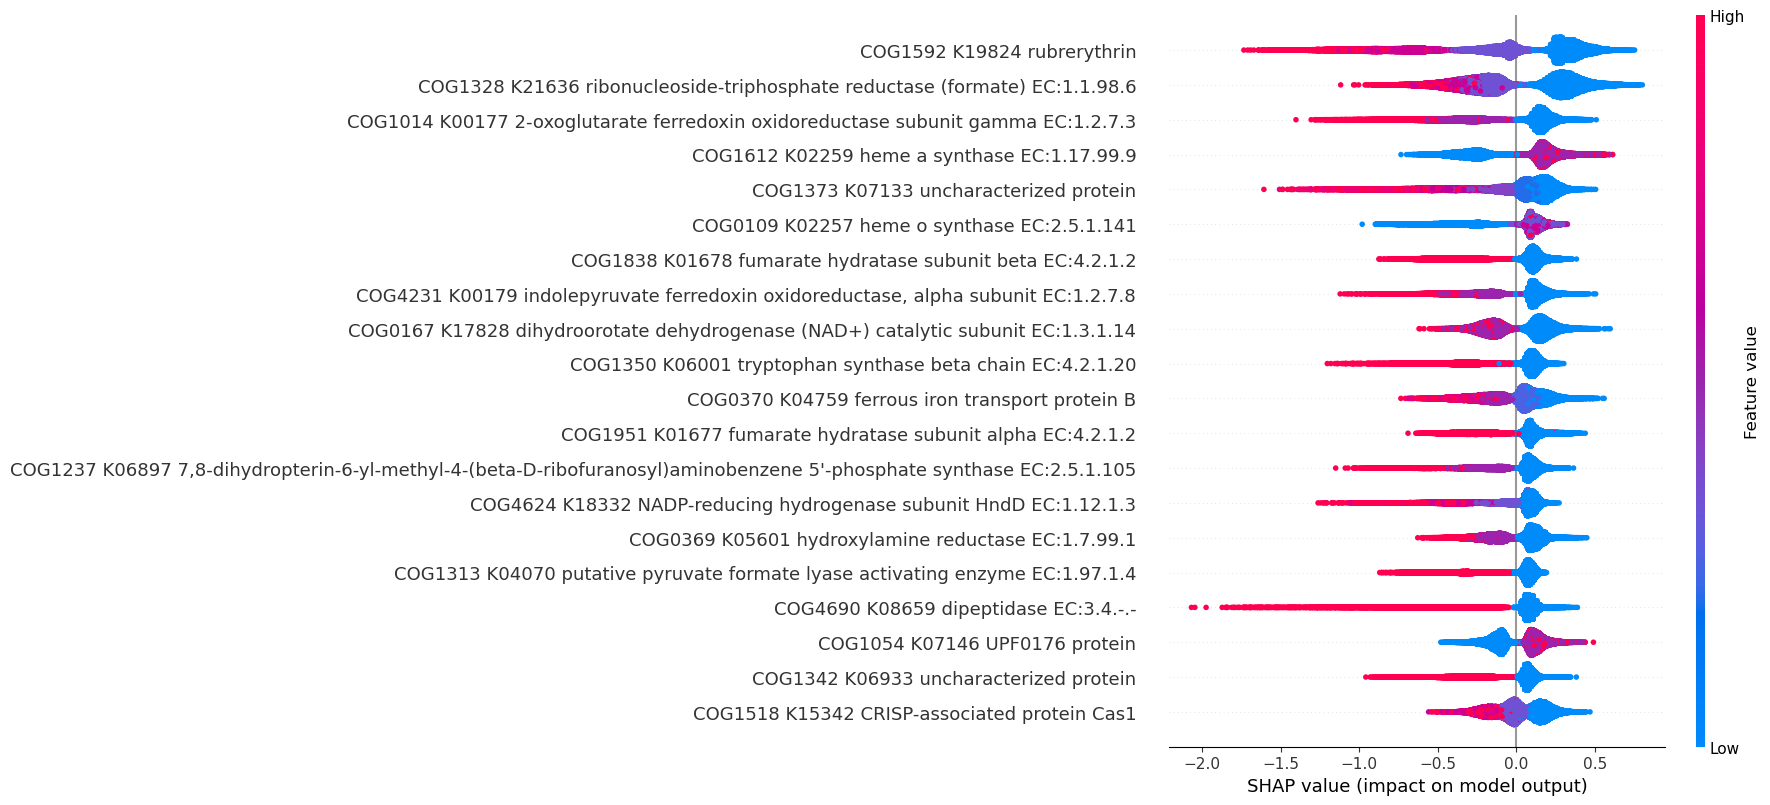

In [10]:
shap.summary_plot(shap_values, X_pred_scaled)

# And on the ancestral predictions, any different?

In [11]:
# modified from 13_apply.py
class Args2:
    x = 'data/TableAncestralRoot1.tsv'
    training_data_header = 'data/all_gene_annotations.added_incompleteness_and_contamination.testing.tsv'
args = Args2()

d = pd.read_csv(args.x, sep="\t")
logging.info("Read in input data of shape {}".format(d.shape))

# Collapse counts of each COG subfamily
d2 = d
d2['COG'] = d2['COG'].str.split('_').str[0]
d3 = d2.groupby('COG').sum()
d4 = d3.transpose()

# Read training data header
eg_data = pl.read_csv(args.training_data_header, separator="\t", has_header=True)
header = eg_data.select(pl.exclude([
    'accession','false_negative_rate','false_positive_rate'
])).columns
# Blacklist these as they aren't in the current ancestral file, not sure why
header = list([h for h in header if h not in ['COG0411', 'COG0459', 'COG0564', 'COG1344', 'COG4177']])

# Reorder columns to be the same as the training dataset
d5 = d4[header]

In [12]:
pred = model.predict(d5)

explainer = shap.TreeExplainer(model.steps[1][1])

X_pred_scaled = pd.DataFrame(model.steps[0][1].transform(d5), columns=d5.columns)
X_pred_scaled.columns = kos_and_names_column_names

shap_values = explainer.shap_values(X_pred_scaled)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


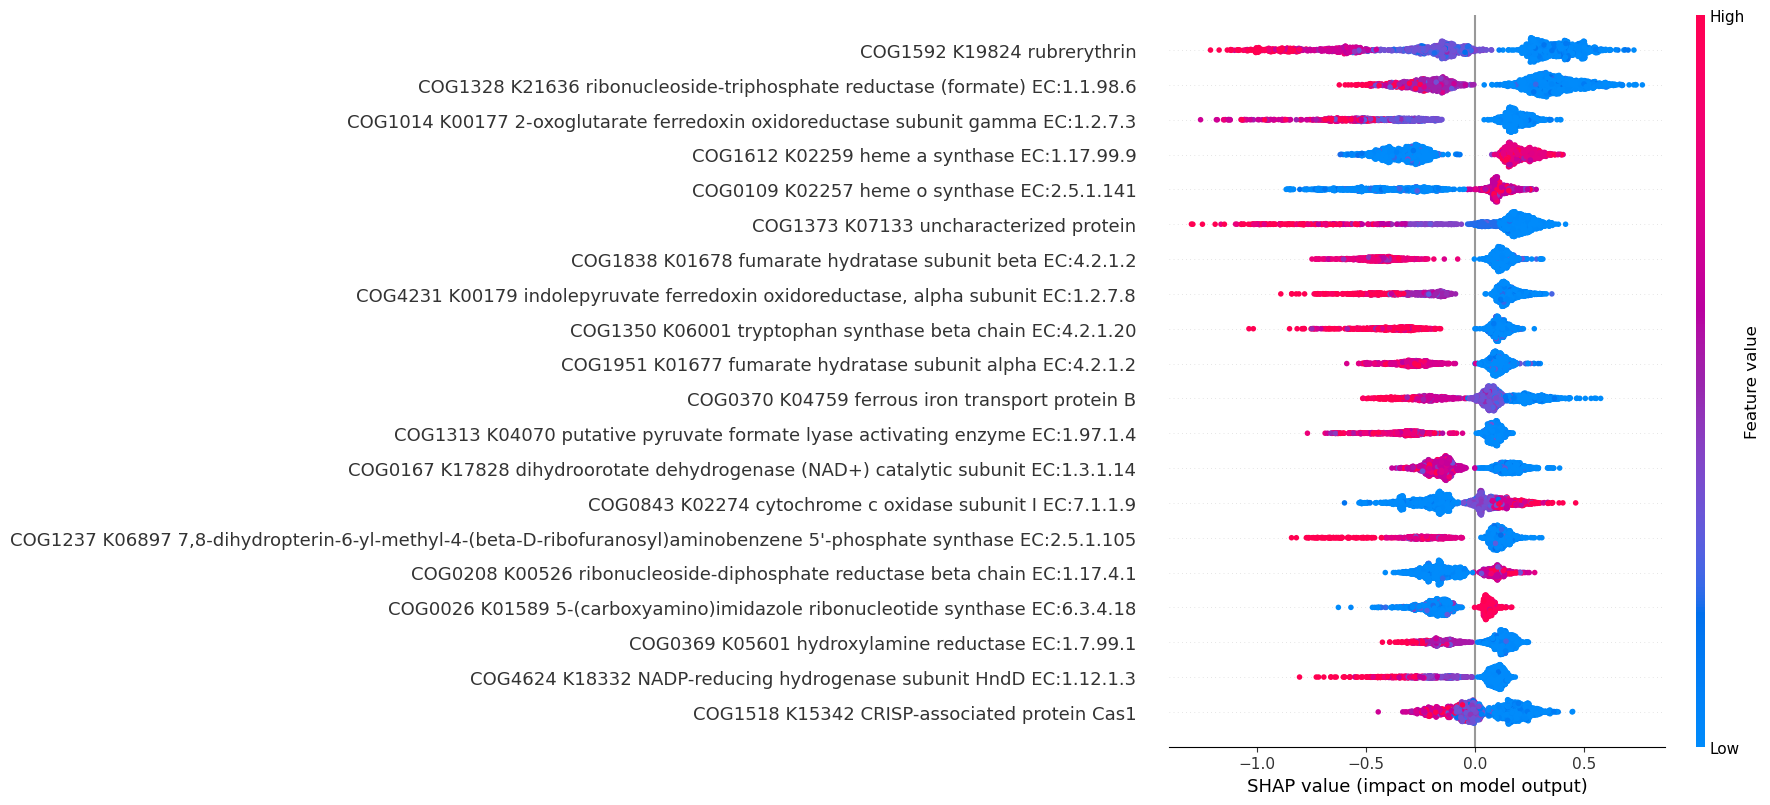

In [13]:
shap.summary_plot(shap_values, X_pred_scaled)

In [14]:
X_pred_scaled

,"COG0001 K01845 glutamate-1-semialdehyde 2,1-aminomutase EC:5.4.3.8",COG0002 K00145 N-acetyl-gamma-glutamyl-phosphate reductase EC:1.2.1.38,COG0003 K01551 arsenite/tail-anchored protein-transporting ATPase EC:7.3.2.7 7.3.-.-,"COG0004 K03320 ammonium transporter, Amt family",COG0005 K00772 5'-methylthioadenosine phosphorylase EC:2.4.2.28,COG0007 K13542 uroporphyrinogen III methyltransferase / synthase EC:2.1.1.107 4.2.1.75,COG0008 K09698 nondiscriminating glutamyl-tRNA synthetase EC:6.1.1.24,COG0010 K01480 agmatinase EC:3.5.3.11,COG0012 K19788 obg-like ATPase 1,COG0013 K01872 alanyl-tRNA synthetase EC:6.1.1.7,...,COG5611 K07064 uncharacterized protein,COG5615 K14166 copper transport protein,COG5621 K20613 kievitone hydratase EC:4.2.1.95,COG5625 K22659 calsyntenin 1,COG5632 K01447 N-acetylmuramoyl-L-alanine amidase EC:3.5.1.28,COG5640 K09640 transmembrane protease serine 9 EC:3.4.21.-,COG5643 K11261 formylmethanofuran dehydrogenase subunit E EC:1.2.7.12,"COG5650 K13671 alpha-1,2-mannosyltransferase EC:2.4.1.-",COG5652 K20950 polysaccharide biosynthesis protein VpsQ,COG5663 K05967 uncharacterized protein
0,0.090909,0.000,0.000000,0.000000,0.000,0.166667,0.142857,0.12500,0.111111,0.083333,...,0.0000,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,0.090909,0.000,0.000000,0.000000,0.000,0.166667,0.000000,0.00000,0.111111,0.083333,...,0.0000,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,0.000000,0.000,0.111111,0.000000,0.000,0.000000,0.142857,0.12500,0.111111,0.083333,...,0.0000,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,0.454545,0.100,0.333333,0.166667,0.200,0.000000,0.285714,0.25000,0.111111,0.083333,...,0.0000,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4,0.090909,0.100,0.333333,0.166667,0.200,0.000000,0.142857,0.00000,0.111111,0.083333,...,0.0000,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,0.050000,0.058,0.084444,0.030833,0.330,0.020000,0.351429,0.13000,0.025556,0.100000,...,0.0025,0.0,0.0025,0.0,0.000000,0.0,0.0,0.0,0.001429,0.0
2009,0.023636,0.038,0.010000,0.025833,0.182,0.040000,0.097143,0.01000,0.111111,0.040000,...,0.0050,0.0,0.0000,0.0,0.001818,0.0,0.0,0.0,0.012857,0.0
2010,0.021818,0.051,0.101111,0.010833,0.140,0.010000,0.230000,0.08500,0.016667,0.078333,...,0.0025,0.0,0.0075,0.0,0.000000,0.0,0.0,0.0,0.001429,0.0
2011,0.007273,0.007,0.015556,0.006667,0.058,0.008333,0.125714,0.02875,0.014444,0.055833,...,0.0000,0.0,0.0025,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


In [15]:
d3

,AABM5X1(0),AABM5X2(1),AABM5X3(2),Abys1(3),Acid1(4),Acid10(5),Acid11(6),Acid12(7),Acid13(8),Acid14(9),...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
COG,,,,,,,,,,,,,,,,,,,,,
COG0001,1,1,0,5,1,2,1,1,1,1,...,1.15,0.58,1.26,0.55,0.76,0.55,0.26,0.24,0.08,0.0
COG0002,0,0,0,1,1,1,0,1,0,1,...,1.48,0.61,1.63,0.74,1.57,0.58,0.38,0.51,0.07,0.0
COG0003,0,0,1,3,3,1,0,2,2,2,...,0.21,1.22,0.28,1.25,0.16,0.76,0.09,0.91,0.14,0.0
COG0004,0,0,0,2,2,0,1,0,0,1,...,1.45,0.60,1.50,0.36,0.88,0.37,0.31,0.13,0.08,0.0
COG0005,0,0,0,1,1,0,1,1,1,1,...,2.01,2.91,1.16,2.24,1.02,1.65,0.91,0.70,0.29,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COG5640,0,0,0,0,0,0,0,0,0,0,...,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
COG5643,0,0,0,0,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
COG5650,0,0,0,0,0,1,2,0,0,0,...,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.0
